### This script contains the following:
#### 1. Import libraries
#### 2. Import data
#### 3. Subsetting and wrangling time-series data
#### 4. Data cleaning
#### 5. Time series analysis: decomposition
#### 6. Testing for stationarity
#### 7. Stationarizing time series data | Method: Differencing

## Import Libraries

In [3]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how the plots will appear.

### **Note**   
#### My project already contain a time series data, so i will import the 'gun violence' data and use that to conduct my time series analysis. 

## Import data

In [4]:
#folder path
path=r'C:\Users\oluwo\Downloads\Gun Violence Project Analysis 2025'

In [5]:
df = pd.read_csv(os.path.join(path, '02. Data', 'Prepared Data', 'gun_violence_cleaned.csv'), index_col=False)

In [6]:
df.shape

(239677, 20)

In [7]:
#drop the column with 'unnamed:0'df.drop(columns=["Unnamed: 0"])
df = df.drop(columns=["Unnamed: 0"])

In [8]:
df.shape

(239677, 19)

In [9]:
#convert date column to date time
df['date'] = pd.to_datetime(df['date'])

In [10]:
df.dtypes

incident_id                          int64
date                        datetime64[ns]
state                               object
city_or_county                      object
address                             object
n_killed                             int64
n_injured                            int64
source_url                          object
gun_stolen                          object
gun_type                            object
incident_characteristics            object
latitude                           float64
longitude                          float64
n_guns_involved                      int64
notes                               object
participant_age_group               object
participant_gender                  object
participant_status                  object
participant_type                    object
dtype: object

My decision to use 'date' as the time index and 'incident_id' to count incidents for the time series is straightforward. Using date allow me to  organize the data chronologically, while counting incident_ids provides an accurate measure of the number of incidents at each point in time. Together, these variables create a clear, time-resolved record of gun violence, capturing trends, patterns, and changes over time. This is exactly what is needed for meaningful time series analysis, including trend detection, seasonal patterns and forecasting future incidents.

## Subsetting and wrangling time-series data

In [11]:
#select variables that are needed for the time series analysis
sub = df[['date', 'incident_id']].copy()

In [12]:
sub.head()

,date,incident_id
0,2013-01-01,461105
1,2013-01-01,460726
2,2013-01-01,478855
3,2013-01-05,478925
4,2013-01-07,478959


In [13]:
sub.shape

(239677, 2)

In [14]:
#Group 'incident id' by date and count unique incidents
incident_count =  sub.groupby('date')['incident_id'].nunique()

In [15]:
incident_count.head()

date
2013-01-01    3
2013-01-05    1
2013-01-07    2
2013-01-19    1
2013-01-21    2
Name: incident_id, dtype: int64

In [16]:
incident_count.shape

(1725,)

In [17]:
#Create a DataFrame from the series
time_series_df = incident_count.reset_index()  # converts series to DataFrame

In [18]:
#rename the variable
time_series_df.rename(columns={'incident_id': 'incident_count'}, inplace=True)

In [19]:
#check output
time_series_df

,date,incident_count
0,2013-01-01,3
1,2013-01-05,1
2,2013-01-07,2
3,2013-01-19,1
4,2013-01-21,2
...,...,...
1720,2018-03-27,135
1721,2018-03-28,175
1722,2018-03-29,131
1723,2018-03-30,114


In [20]:
#Resample by month and count incidents
incident_monthly = time_series_df.set_index('date').resample('M')['incident_count'].count()

In [21]:
#check output
incident_monthly

date
2013-01-31     8
2013-02-28    11
2013-03-31    15
2013-04-30    12
2013-05-31    20
              ..
2017-11-30    30
2017-12-31    31
2018-01-31    31
2018-02-28    28
2018-03-31    31
Freq: ME, Name: incident_count, Length: 63, dtype: int64

In [22]:
# Convert the Series to a DataFrame
incident_monthly_df = incident_monthly.reset_index()

In [23]:
incident_monthly_df

,date,incident_count
0,2013-01-31,8
1,2013-02-28,11
2,2013-03-31,15
3,2013-04-30,12
4,2013-05-31,20
...,...,...
58,2017-11-30,30
59,2017-12-31,31
60,2018-01-31,31
61,2018-02-28,28


In [24]:
# Setting the 'date' column as the index and removing the 'indicator' column

data = incident_monthly_df.set_index('date')

In [25]:
data

,incident_count
date,
2013-01-31,8
2013-02-28,11
2013-03-31,15
2013-04-30,12
2013-05-31,20
...,...
2017-11-30,30
2017-12-31,31
2018-01-31,31


In [157]:
data.columns

Index(['incident_count'], dtype='object')

In [158]:
type(data)

pandas.core.frame.DataFrame

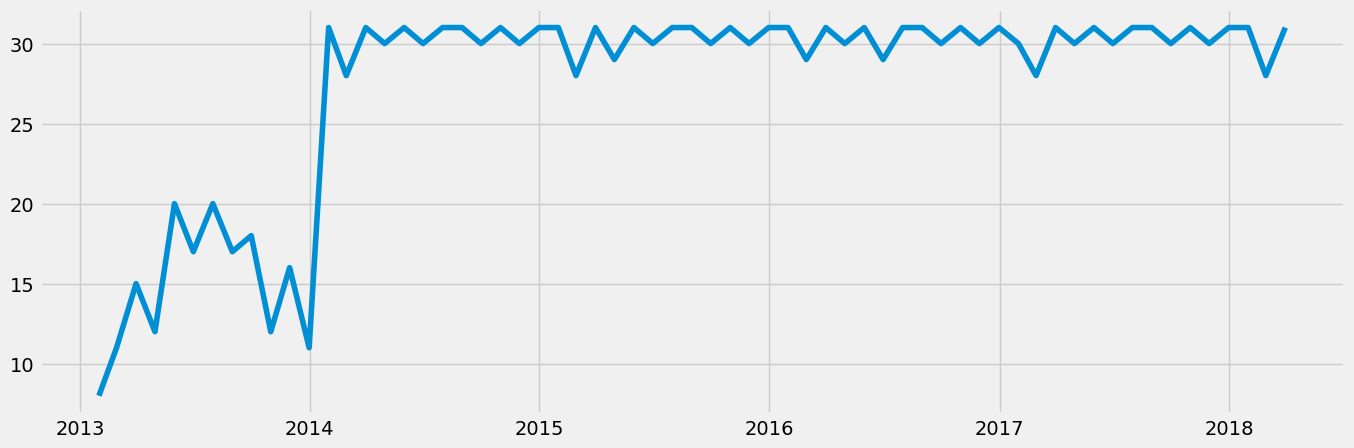

In [159]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

The early period of the dataset (2013 to early 2014) exhibits unusually high volatility and a pronounced structural break, which is possibly driven by incomplete data coverage or changes in reporting practices rather than true underlying trends in gun violence.   
Including this period in time series modeling could distort trend estimation and reduce model reliability. Therefore, to ensure a more stable, consistent, and reliable time series that is appropriate for modeling and forecasting, the subsequent analysis will focus on data from 2014 through 2018, where incident counts appear more stable and systematically recorded.

In [160]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [161]:
data_2.head()

,date,incident_count
0,2013-01-31,8
1,2013-02-28,11
2,2013-03-31,15
3,2013-04-30,12
4,2013-05-31,20


In [162]:
data_sub = data_2.loc[(data_2['date'] >= '2014-01-01') & (data_2['date'] <= '2018-03-31')]

In [163]:
data_sub.shape

(51, 2)

In [164]:
data_sub.head()

,date,incident_count
12,2014-01-31,31
13,2014-02-28,28
14,2014-03-31,31
15,2014-04-30,30
16,2014-05-31,31


In [165]:
# Set the "date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['date'], axis=1, inplace=True) # Drop the "date" column.
data_sub.head()

,incident_count
datetime,
2014-01-31,31
2014-02-28,28
2014-03-31,31
2014-04-30,30
2014-05-31,31


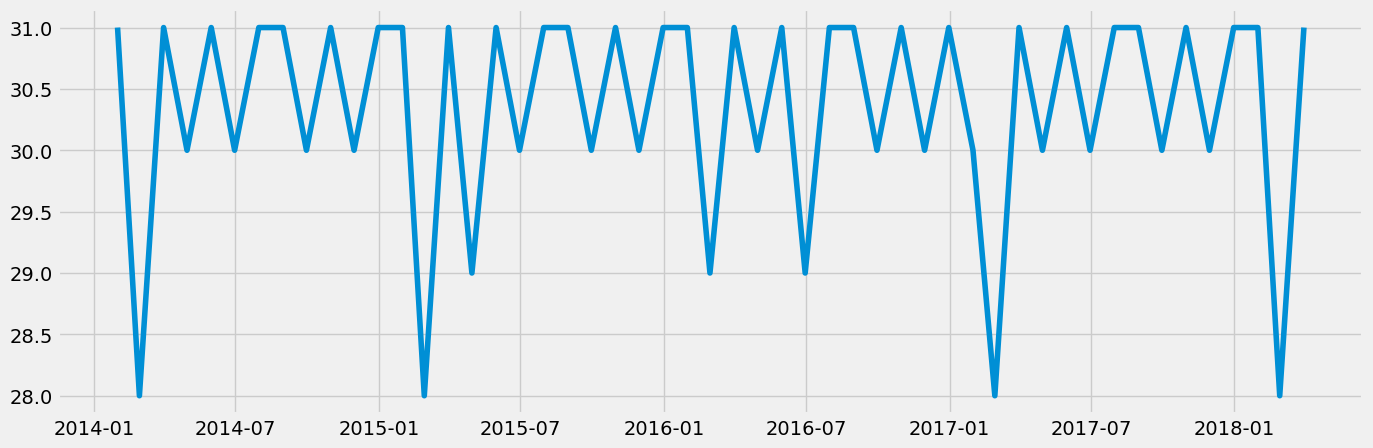

In [166]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

## Data cleaning

In [167]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

incident_count    0
dtype: int64

In [168]:
# Check for duplicates

dups = data.duplicated()
dups.sum()

# No dups

np.int64(51)

## Time-series analysis: decomposition

**Question 5**   
Decompose the data’s components.

Analyze the results from the plot in a markdown cell.


In [169]:
#Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [170]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

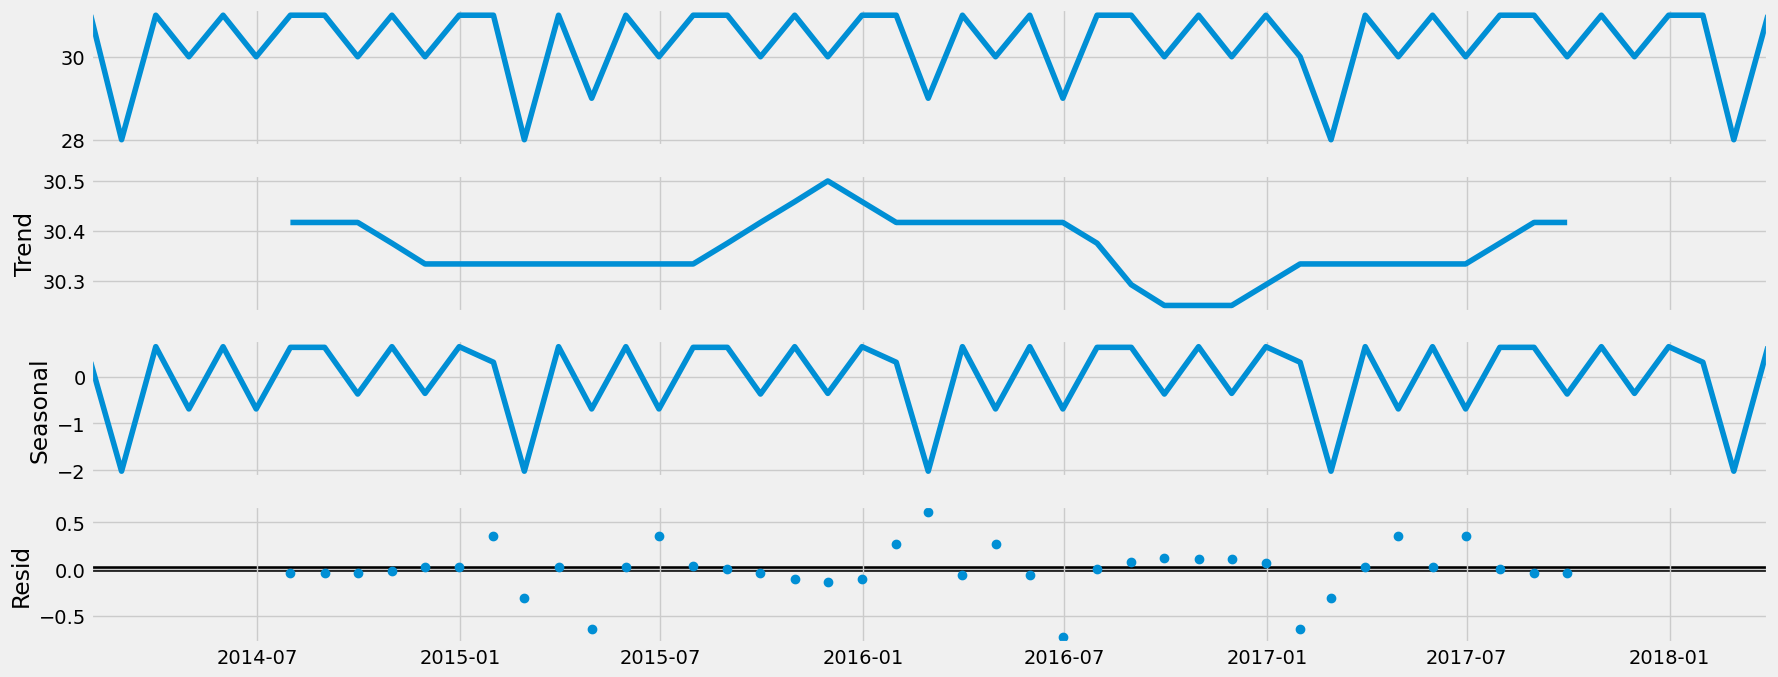

In [171]:
#Plot the separate components

decomposition.plot()
plt.show()

**Level** shows monthly gun violence incidents fluctuating within a narrow range of approximately 30–31 incidents per month. These fluctuations are regular and predictable rather than extreme or erratic, with no sudden spikes, sharp drops, or shifts in the overall level of the series. This consistent behavior indicates a stable data-generating process over time and supports the decision to restrict the analysis to the 2014–2018 period, where reporting appears complete and reliable.

**Trend** further reinforces this stability. It is smooth and shallow, remaining within a tight band between roughly 30.25 and 30.5 incidents per month. Minor movements are visible, including a slight dip around mid-2015, a gradual rise into early 2016, followed by another modest decline in late 2016, after which the trend stabilizes through 2017 and 2018. Importantly, there is no sustained upward or downward movement, indicating the absence of a long-term growth or decline in incident frequency. This confirms that the series does not exhibit a structural break, nor does it reflect any major policy change or reporting shock, making it well suited for trend and seasonal analysis.

**Seasonal** is strong and remarkably consistent across years. The same months repeatedly exhibit negative deviations of about −2 incidents and positive deviations of approximately +1 incident. This regular repetition suggests a stable annual seasonal cycle, likely influenced by recurring social, environmental, or calendar-related factors. The persistence and uniform magnitude of this pattern indicate stationary seasonality, validating the use of monthly time aggregation and strengthening the case for seasonal time-series modeling.

**Residual** is well-behaved. Residuals are tightly centered around zero, small in magnitude (mostly within ±0.5), and show no visible clustering, trending, or systematic patterns. This indicates that the combination of trend and seasonality effectively captures most of the variation in the data. There is no evidence of missing structure, hidden regime changes, or unexplained shocks during the 2014–2018 period.

**Overall Conclusion**  
Together, the decomposition results demonstrate that the 2014–2018 gun violence incident series is stable, well-structured, and highly suitable for time-series analysis. The data exhibit a consistent level, a mild and interpretable trend, strong and stationary seasonality, and minimal unexplained noise. These characteristics confirm the reliability of the selected time window and support its use for forecasting, seasonal modeling, and further inferential analysis.

 ## Testing for stationarity

**Question 6**  
Conduct a Dickey-Fuller test to check for stationarity.

Interpret the results in a markdown cell and reference your null hypothesis

In [172]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['incident_count'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.099147
p-value                         0.244858
Number of Lags Used            11.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


**Interpretation**  
Test Statistic (-2.099147) is greater than all critical values(-3.610400, -2.939109, -2.608063)    
p-value (0.244858) is greater than 0.05.

**meaning**   
Test statistic larger than critical value = can’t reject null hypothesis     
there is a unit root in the data, and data is non-stationary. 

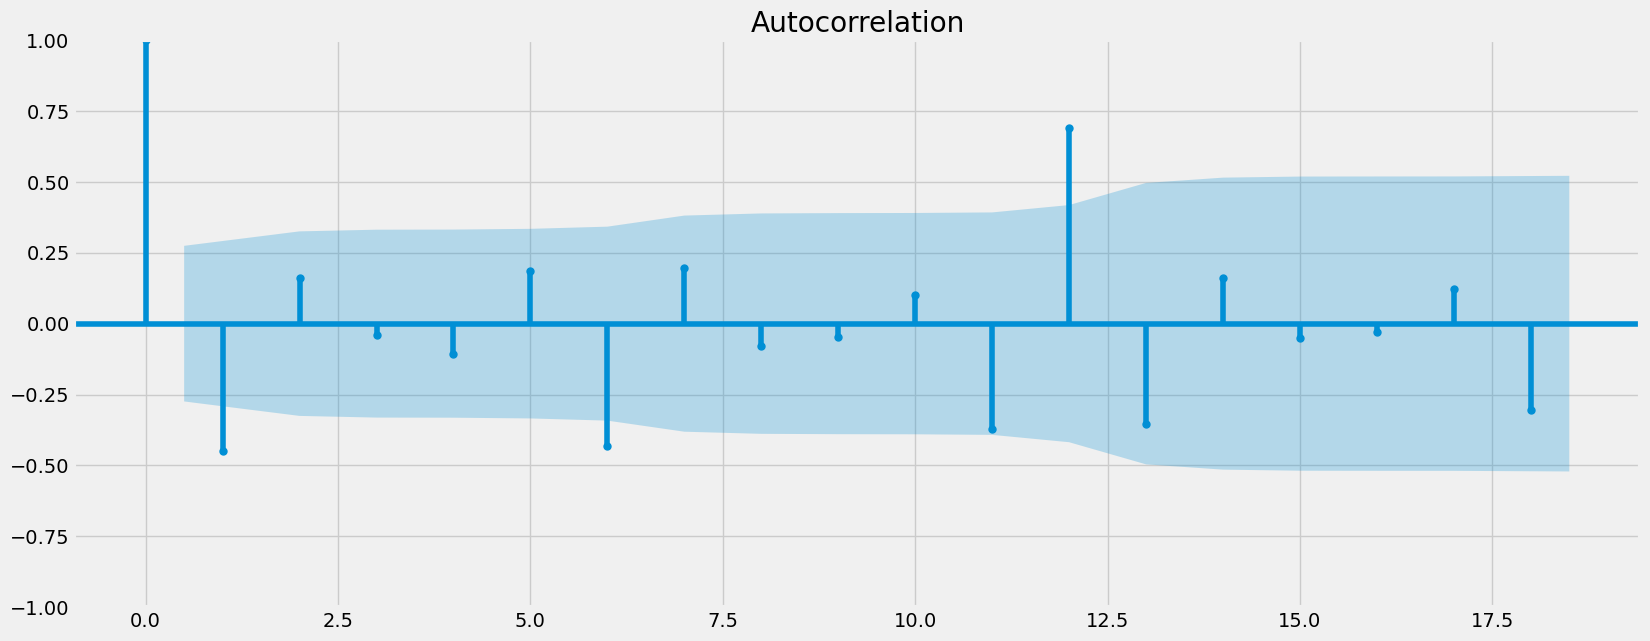

In [173]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

**Interpretation**  
few of the vertical lines are beyond the confidence interval, which clearly indicates that the data is non-stationary

## Stationarizing time series data | Method: Differencing

**Question 7**  
If your data isn’t stationary, conduct a round of differencing on it and repeat step 6

In [174]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [175]:
data_diff.dropna(inplace = True) #remove the missing values that came about as a result of the differencing, to be able to run the Dickey-Fuller test. 

In [176]:
data_diff.head()

,incident_count
datetime,
2014-02-28,-3.0
2014-03-31,3.0
2014-04-30,-1.0
2014-05-31,1.0
2014-06-30,-1.0


In [177]:
data_diff.columns

Index(['incident_count'], dtype='object')

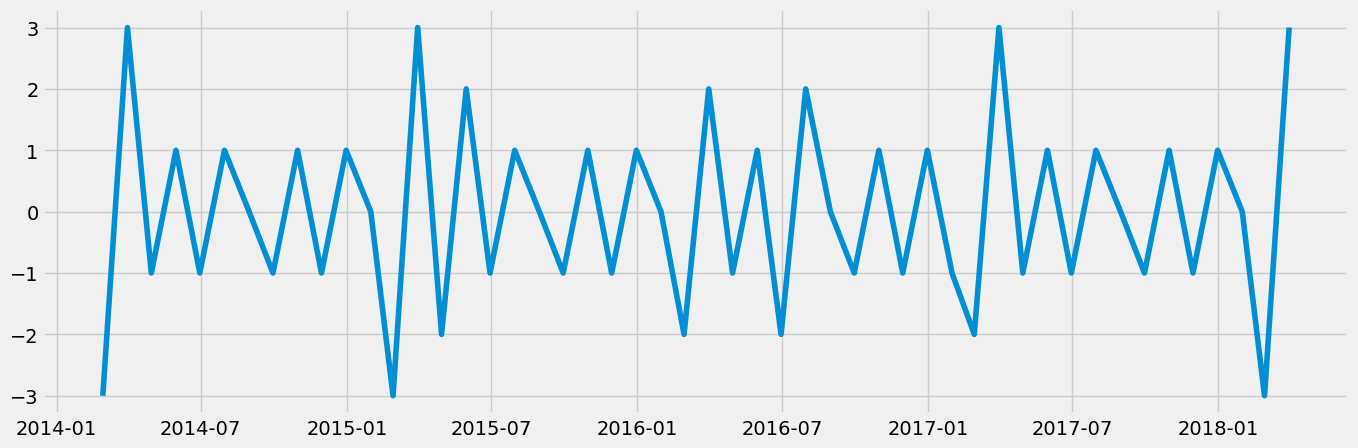

In [178]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [179]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -7.025412e+00
p-value                        6.383451e-10
Number of Lags Used            1.000000e+01
Number of Observations Used    3.900000e+01
Critical Value (1%)           -3.610400e+00
Critical Value (5%)           -2.939109e+00
Critical Value (10%)          -2.608063e+00
dtype: float64


**Interpretation**  
Test Statistic (-7.025412e+00) is smaller than all critical values(-3.610400e+00, -2.939109e+00, -2.608063e+00)    
p-value (6.383451e-10) is smaller than 0.05.

**meaning**   
Test statistic smaller than critical value = can reject null hypothesis    
there is no unit root in the data, and data is stationary. 

**Question 9**   
Check your data’s autocorrelations.

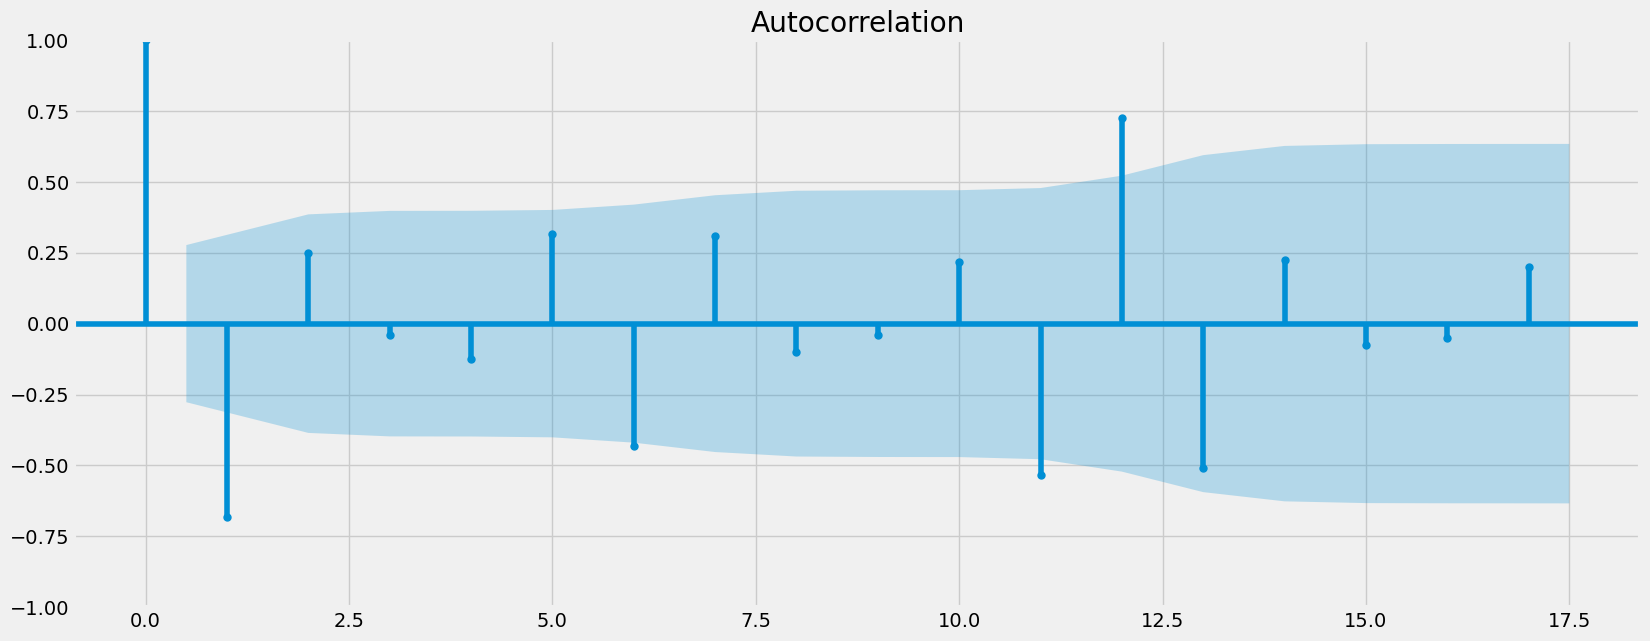

In [182]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_diff)
plt.show()

After the first round of differencing, the ACF plot shows that most autocorrelation values fall within the confidence band, with no sign of slow decay or long-run persistence. This indicates that the series no longer contains a unit root and is now stationary.   

**Note**   
A few significant spikes especially at lag 12 reflect seasonal structure rather than non-stationarity.